In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 256,256 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

InceptionV3_model = InceptionV3(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

InceptionV3_model.trainable=False

In [6]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in InceptionV3_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001E1AE3EF448>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E1A238AFC8>,conv2d,False
2,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001E1AE3ED808>,batch_normalization,False
3,<tensorflow.python.keras.layers.core.Activation object at 0x000001E1AEBA2648>,activation,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E1AED6F588>,conv2d_1,False
...,...,...,...
306,<tensorflow.python.keras.layers.core.Activation object at 0x000001E4694ABC48>,activation_85,False
307,<tensorflow.python.keras.layers.merge.Concatenate object at 0x000001E4695BC408>,mixed9_1,False
308,<tensorflow.python.keras.layers.merge.Concatenate object at 0x000001E469725988>,concatenate_1,False
309,<tensorflow.python.keras.layers.core.Activation object at 0x000001E469778F08>,activation_93,False


In [7]:
InceptionV3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [9]:

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical 
from keras import optimizers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization

#from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix# build model architecture 
model = Sequential()
model.add(InceptionV3_model)
#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_class, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())
print("Las métricas del modelo son: ",model.metrics_names)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               18874624  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 40,677,922
Trainable params: 18,875,138
Non-trainable params: 21,802,784
_________________________________________________________________
None
Las métricas del modelo son:  ['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m']


In [10]:
import time
inicio=time.time()
history = model.fit_generator(train, 
                              epochs=10,  
                              validation_data=val,
                              verbose=1)
fin=time.time()
print(inicio-fin)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 454 steps, validate for 113 steps
Epoch 1/10
454/454 [==============================] - 49s 109ms/step - loss: 0.4540 - accuracy: 0.8526 - f1_m: 0.8527 - precision_m: 0.8527 - recall_m: 0.8527 - val_loss: 0.5683 - val_accuracy: 0.7225 - val_f1_m: 0.7226 - val_precision_m: 0.7226 - val_recall_m: 0.7226
Epoch 2/10
454/454 [==============================] - 41s 89ms/step - loss: 0.3903 - accuracy: 0.9222 - f1_m: 0.9224 - precision_m: 0.9224 - recall_m: 0.9224 - val_loss: 0.5953 - val_accuracy: 0.6893 - val_f1_m: 0.6894 - val_precision_m: 0.6894 - val_recall_m: 0.6894
Epoch 3/10
454/454 [==============================] - 41s 90ms/step - loss: 0.3675 - accuracy: 0.9471 - f1_m: 0.9472 - precision_m: 0.9472 - recall_m: 0.9472 - val_loss: 0.5651 - val_accuracy: 0.7272 - val_f1_m: 0.7273 - val_precision_m: 0.7273 - val_recall_m: 0.7273
Epoch 4/10
454/454 [=====

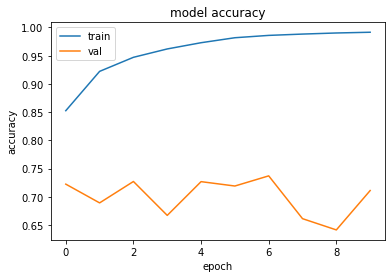

-0.5263721942901611


In [11]:
# summarize history for accuracy
import time
inicio=time.time()
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fin=time.time()
print(inicio-fin)

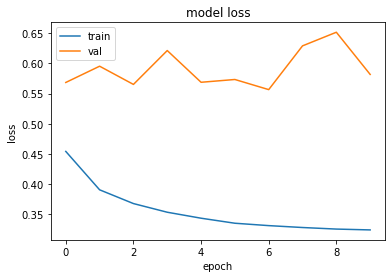

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

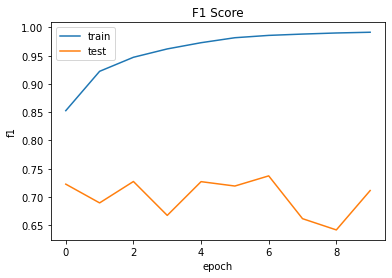

In [13]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

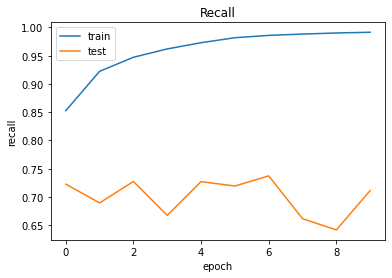

In [14]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

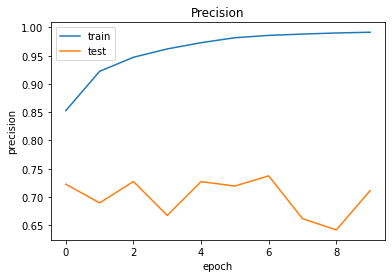

In [15]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

  ...
    to  
  ['...']
142/142 [==============================] - 11s 76ms/step - loss: 0.5557 - accuracy: 0.7398 - f1_m: 0.7400 - precision_m: 0.7400 - recall_m: 0.7400
El modelo predice el  73.98015260696411 % de los datos


In [17]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.5557071035596687
Accuracy:  0.7398015
F1 Score:  0.7399724
Precision:  0.7399725
Recall:  0.7399725
